# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [1]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
# !pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.3 opencv-python==4.8.0.76 -q --user

In [2]:
# Installing the libraries with the specified version.
# uncomment and run the following lines if Jupyter Notebook is being used
#!pip install tensorflow==2.13.0 scikit-learn==1.2.2 seaborn==0.11.1 matplotlib==3.3.4 numpy==1.24.3 pandas==1.5.2 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
#import math
import cv2
import seaborn as sns

import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Display images using OpenCV
# from google.colab.patches import cv2_imshow
from tensorflow.keras import backend

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [4]:
# Uncomment and run the below code if you are using google colab
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Load a NumPy array containing images from the specified file path
images = np.load('./images.npy')
# Read a CSV file containing labels using pandas from the specified file path
labels = pd.read_csv('./Labels.csv')

In [6]:
# function to plot the BGR images in RGB format
def cv2_imshow(cv2image):
    # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format) for proper display
    plt.imshow(cv2.cvtColor(cv2image, cv2.COLOR_BGR2RGB))
    
    # Turn off the axis labels and ticks for a cleaner display
    plt.axis('off')
    
    # Display the image
    plt.show()

In [7]:
# This function will remove all colors but green range 
def replace_colors_except_green(image, lower_h=20, lower_s=50, lower_v=50, upper_h=90, upper_s=255, upper_v=255):
    # Load the image
    image = image
    
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define the green color range in HSV
    # Adjust these ranges for plant greens
    lower_green = np.array([lower_h, lower_s, lower_v])  
    upper_green = np.array([upper_h, upper_s, upper_v])
    
    # Create a mask for the green areas
    mask = cv2.inRange(hsv_image, lower_green, upper_green)
    
    # Create an all-black image
    black_image = np.ones_like(image)
    
    # Use the mask to copy only green regions from the original image
    green_image = cv2.bitwise_and(image, image, mask=mask)
    
    # Combine black image and green image using the mask
    result = np.where(mask[:, :, None].astype(bool), green_image, black_image)
    
    return result

## Data Overview

### Understand the shape of the dataset

In [8]:
# Print the shape (dimensions) of the images array,
# which gives the number of images and their dimensions (height, width, channels)
print(images.shape)

# Print the shape (dimensions) of the labels dataframe,
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


* There are 4750 RGB  images of shape 128 x 128 X 3, each image having 3 channels.
* There are 4750 labels

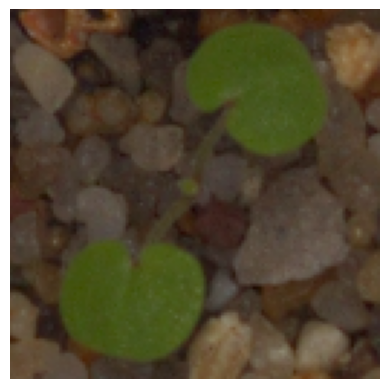

In [9]:
# Display sample image from the images array using OpenCV's imshow function.
cv2_imshow(images[5])

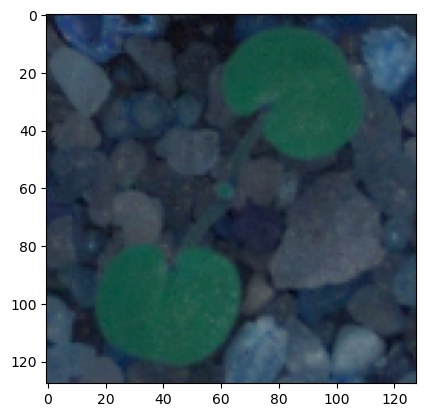

In [10]:
# Display sample image from the images array using Matplotlib's imshow function.
plt.imshow(images[5]);

* We can observe that the images are being shown in different colors when plotted with openCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV.
* We will convert these BGR images to RGB images later.

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

### Plotting random images from each of the class

In [11]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])
          ax.set_title(keys[random_index])
  plt.show()

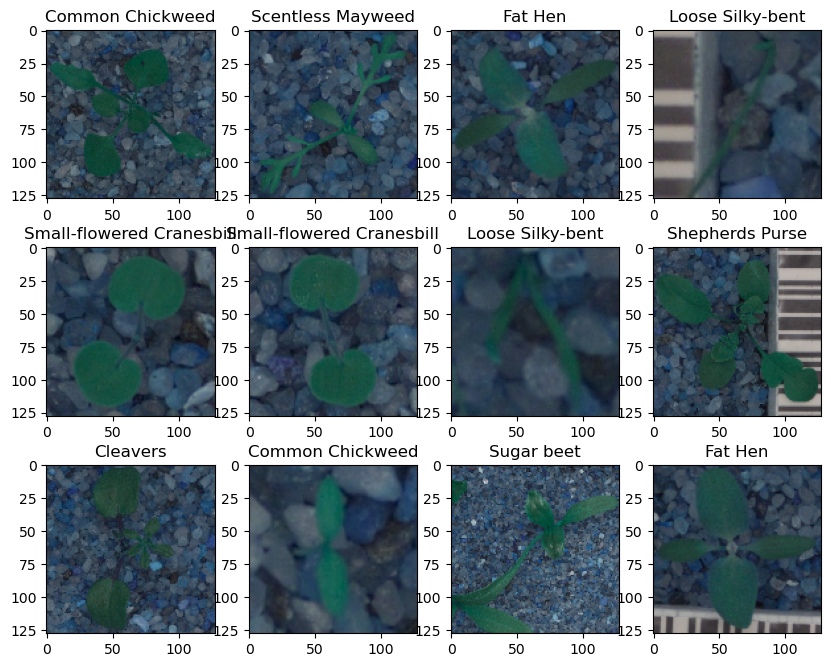

In [12]:
plot_images(images, labels)

### Checking for data imbalance

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600'),
  Text(700.0, 0, '700')])

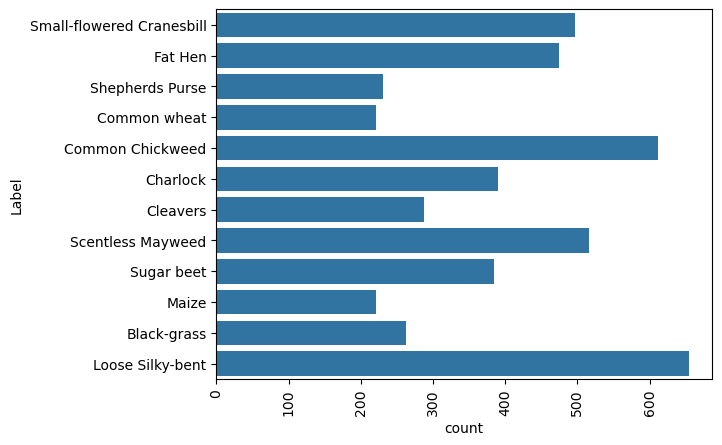

In [13]:
 # Plot labels
 sns.countplot(labels['Label'])
 plt.xticks(rotation='vertical')

* The dataset is imbalanced
* "Loose Silky-bent" and "Common Chickweed" are morethan others and least plant samples are , "Maize", "Common Wheat", "Shepherds Purse"

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [14]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Converting images to blck and green
* As the plants are in a range of green by doing this will remove most of the noises

In [15]:
# Initialize an empty list to store the processed images
black_green_images = []

# Loop through each image in the 'images' list
for i in range(len(images)):
    # Apply the 'replace_colors_except_green' function to the current image
    # and append the result to the 'black_green_images' list
    black_green_images.append(replace_colors_except_green(images[i]))

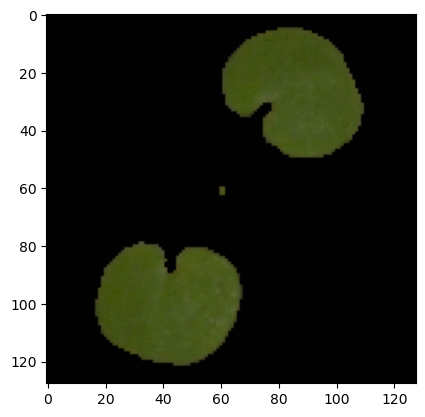

In [16]:
# Plot a sample of converted image to black_green
plt.imshow(black_green_images[5]);

### Resize the images

* As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [17]:
# Initialize an empty list to store the resized images
images_decreased=[]

# Define the target height and width for resizing the images
height = 64  # New height of the image
width = 64   # New width of the image
dimensions = (width, height)


# Loop through each image in the images array
for i in range(len(black_green_images)):
  images_decreased.append( cv2.resize(black_green_images[i], dimensions, interpolation=cv2.INTER_LINEAR))

**Image before resizing**

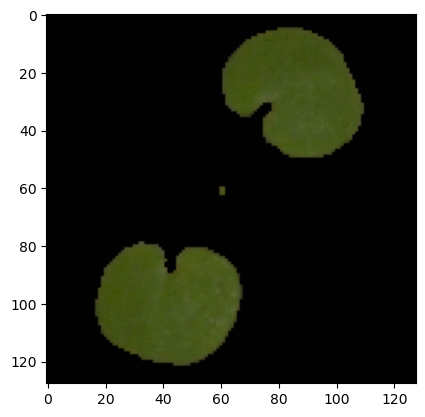

In [18]:
plt.imshow(black_green_images[5]);

**Image after resizing**

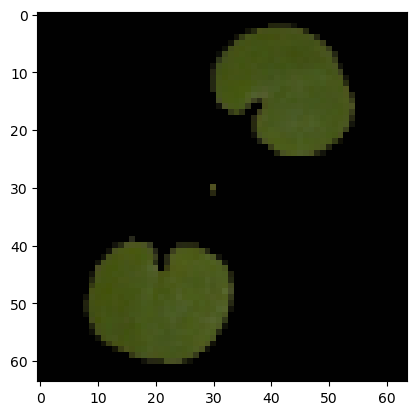

In [19]:
# Display the smample image
plt.imshow(images_decreased[5]);

## Visualizing images using Gaussian Blur

In [20]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(black_green_images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(black_green_images[i], ksize =(3,3),sigmaX =  0))

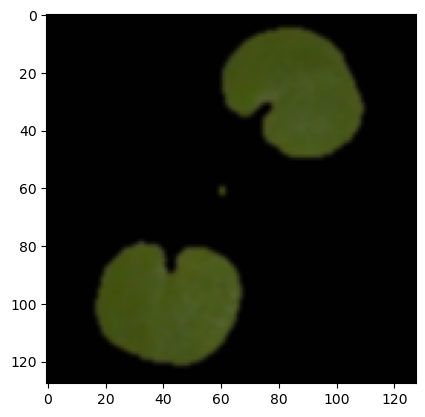

In [21]:
plt.imshow(images_gb[5]);

* It appears that GaussianBlur would be ineffective because the blurred or denoised image does not seem to contain any relevant information, and the model would struggle to categorize these blurred images.

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [22]:
# Split the dataset into training and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased), labels, test_size=0.1, random_state=42, stratify=labels)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42, stratify=y_temp)

In [23]:
# Printing shape of train set, validation set, and test set and target (y)
print("Traing set shape: ", X_train.shape,y_train.shape)
print("Validation set shape: ", X_val.shape,y_val.shape)
print("Test set shape: ", X_test.shape,y_test.shape)

Traing set shape:  (3847, 64, 64, 3) (3847, 1)
Validation set shape:  (428, 64, 64, 3) (428, 1)
Test set shape:  (475, 64, 64, 3) (475, 1)


### Encode the target labels

In [24]:
# Convert labels from names to one hot vectors
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [25]:
print(len(enc.classes_))

12


* We have 12 unique classes

In [26]:
# Printing shape of target labels after encoding
print("Encoded Traing target shape: ", y_train_encoded.shape)
print("Encoded Validation target shape: ", y_val_encoded.shape)
print("Encoded Test target shape: ", y_test_encoded.shape)

Encoded Traing target shape:  (3847, 12)
Encoded Validation target shape:  (428, 12)
Encoded Test target shape:  (475, 12)


### Data Normalization

* Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [27]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

In [28]:
# Printing shape of data after normalizing
print("Normalized Traing set shape: ", X_train_normalized.shape)
print("Normalized Validation set shape: ", X_val_normalized.shape)
print("Normalized Test set shape: ", X_test_normalized.shape)

Normalized Traing set shape:  (3847, 64, 64, 3)
Normalized Validation set shape:  (428, 64, 64, 3)
Normalized Test set shape:  (475, 64, 64, 3)


## Model Building

In [29]:
# Clearing backend
backend.clear_session()

In [30]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [31]:
model1 = Sequential()

# Input layer (64x64x3)
model1.add(Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(64, 64, 3)))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Block
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Block
model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D(pool_size=(2, 2)))


# Flatten and Fully Connected Layers
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))

# Output Layer (with softmax for multi-class classification)
model1.add(Dense(12, activation='softmax'))

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Generating the summary of the model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 565,484 (2.16 MB)

 Trainable params: 565,484 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

**Fitting the model on the train data**

In [32]:
history_1 = model1.fit(X_train_normalized, y_train_encoded,
                      epochs=30,
                      validation_data=(X_val_normalized, y_val_encoded),
                      batch_size=32,
                      verbose=2
                      )

Epoch 1/30
121/121 - 3s - 23ms/step - accuracy: 0.3114 - loss: 1.9760 - val_accuracy: 0.4673 - val_loss: 1.5303
Epoch 2/30
121/121 - 2s - 19ms/step - accuracy: 0.5214 - loss: 1.3841 - val_accuracy: 0.6402 - val_loss: 1.0491
Epoch 3/30
121/121 - 2s - 19ms/step - accuracy: 0.6712 - loss: 0.9402 - val_accuracy: 0.7383 - val_loss: 0.7798
Epoch 4/30
121/121 - 2s - 19ms/step - accuracy: 0.7427 - loss: 0.7585 - val_accuracy: 0.7126 - val_loss: 0.8494
Epoch 5/30
121/121 - 2s - 19ms/step - accuracy: 0.7905 - loss: 0.6005 - val_accuracy: 0.7079 - val_loss: 0.8479
Epoch 6/30
121/121 - 2s - 19ms/step - accuracy: 0.8196 - loss: 0.5256 - val_accuracy: 0.7196 - val_loss: 0.8365
Epoch 7/30
121/121 - 2s - 20ms/step - accuracy: 0.8321 - loss: 0.4627 - val_accuracy: 0.6893 - val_loss: 0.9690
Epoch 8/30
121/121 - 2s - 20ms/step - accuracy: 0.8534 - loss: 0.4154 - val_accuracy: 0.7921 - val_loss: 0.7000
Epoch 9/30
121/121 - 2s - 20ms/step - accuracy: 0.8669 - loss: 0.3622 - val_accuracy: 0.7850 - val_loss:

### **Model Evaluation**

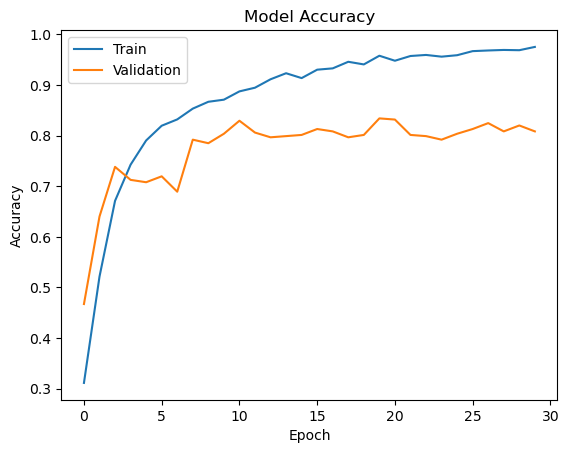

In [33]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**


*   We can see from the above plot that both training and validation has a good accuracy but, as can be seen there are signs of overfitting.


### **Evaluating the model on test data**

In [34]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - 7ms/step - accuracy: 0.7874 - loss: 0.9591


### **Generating the predictions using test data**

In [35]:
# Here we would get the output as probablities for each category
y_pred=model1.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [36]:
y_pred

array([[1.5218820e-17, 1.7039393e-17, 3.4404875e-11, ..., 6.2986583e-10,
        9.6033851e-15, 1.1781507e-08],
       [2.1477958e-30, 3.2738899e-07, 1.6177920e-10, ..., 5.3301572e-09,
        9.9999964e-01, 1.1786066e-15],
       [1.2706075e-21, 4.1692133e-10, 9.5065580e-11, ..., 3.5093919e-09,
        1.0000000e+00, 6.3598558e-12],
       ...,
       [2.1479648e-02, 1.9133467e-10, 7.5532688e-07, ..., 3.6978334e-11,
        1.6188164e-11, 8.5876046e-08],
       [3.1412235e-08, 5.0790607e-07, 2.9462902e-07, ..., 3.0559727e-03,
        1.0213105e-08, 2.4938484e-04],
       [1.0116278e-11, 4.1377612e-07, 1.4670682e-05, ..., 8.8150781e-01,
        5.1996141e-04, 1.1124365e-01]], dtype=float32)

### **Plotting the Confusion Matrix**

*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.





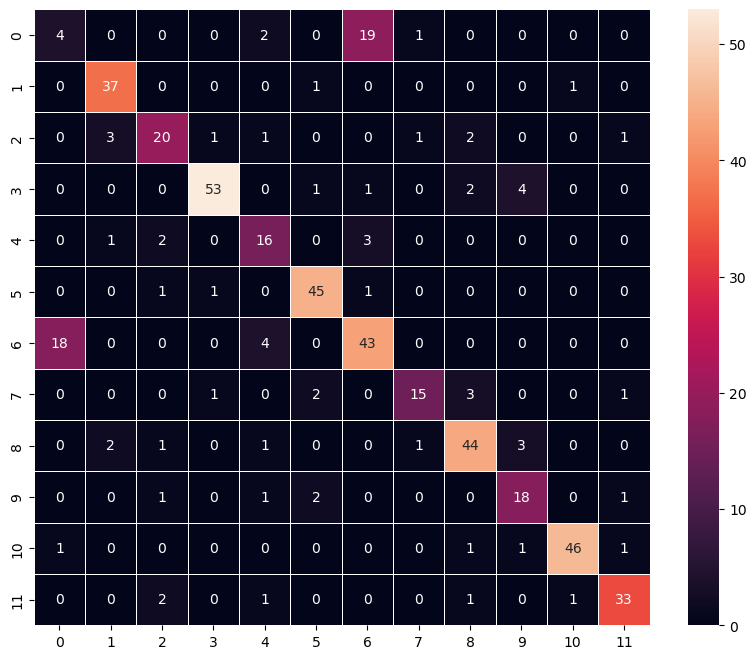

In [37]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Observations**
* We observe that some of the classes are not predicted correctly.
* In comparison to the rest, we can see that classes 3,5, and 6 are well classified.
* We can also observe that classes 0,4, and 7 are mostly misclassified.

In [38]:
# Plotting the classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg)
print(cr)

              precision    recall  f1-score   support

           0       0.17      0.15      0.16        26
           1       0.86      0.95      0.90        39
           2       0.74      0.69      0.71        29
           3       0.95      0.87      0.91        61
           4       0.62      0.73      0.67        22
           5       0.88      0.94      0.91        48
           6       0.64      0.66      0.65        65
           7       0.83      0.68      0.75        22
           8       0.83      0.85      0.84        52
           9       0.69      0.78      0.73        23
          10       0.96      0.92      0.94        50
          11       0.89      0.87      0.88        38

    accuracy                           0.79       475
   macro avg       0.76      0.76      0.75       475
weighted avg       0.79      0.79      0.79       475



* Altough accuracy in this model is reasonable, but as there are signs of overfitting, other models with performance tuining will be trained.

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

**Reducing the Learning Rate:**

In [39]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [40]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [41]:
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'

                              )

In [42]:
model2 = Sequential()

# Input layer (64x64x3)
model2.add(Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(64, 64, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Block
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Block
model2.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected Layers
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))

# Output Layer (with softmax for multi-class classification)
model2.add(Dense(12, activation='softmax'))

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Generating the summary of the model
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,193,740 (8.37 MB)

 Trainable params: 2,193,740 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

**Fitting the model on the train data**

In [43]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

history2 = model2.fit(train_datagen.flow(X_train_normalized, y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized, y_val_encoded),
                                       callbacks=[learning_rate_reduction],
                                       verbose=1,
                                       )


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2115 - loss: 2.2783 - val_accuracy: 0.4743 - val_loss: 1.5363 - learning_rate: 0.0010
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5469 - loss: 1.4912 - val_accuracy: 0.4813 - val_loss: 1.5388 - learning_rate: 0.0010
Epoch 3/30


2024-09-19 15:00:30.105479: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.4900 - loss: 1.5171 - val_accuracy: 0.6449 - val_loss: 1.0916 - learning_rate: 0.0010
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7031 - loss: 1.1109 - val_accuracy: 0.6425 - val_loss: 1.0765 - learning_rate: 0.0010
Epoch 5/30


2024-09-19 15:00:33.413722: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6121 - loss: 1.1454 - val_accuracy: 0.7126 - val_loss: 0.8949 - learning_rate: 0.0010
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - loss: 0.8140 - val_accuracy: 0.6799 - val_loss: 0.9989 - learning_rate: 0.0010
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6802 - loss: 0.9333 - val_accuracy: 0.7780 - val_loss: 0.7171 - learning_rate: 0.0010
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.7607 - val_accuracy: 0.7850 - val_loss: 0.7123 - learning_rate: 0.0010
Epoch 9/30


2024-09-19 15:00:40.020111: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7487 - loss: 0.7683 - val_accuracy: 0.7757 - val_loss: 0.7153 - learning_rate: 0.0010
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7656 - loss: 0.6452 - val_accuracy: 0.7804 - val_loss: 0.6985 - learning_rate: 0.0010
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7725 - loss: 0.6915 - val_accuracy: 0.8084 - val_loss: 0.6436 - learning_rate: 0.0010
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7656 - loss: 0.7228 - val_accuracy: 0.8131 - val_loss: 0.6391 - learning_rate: 0.0010
Epoch 13/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7994 - loss: 0.6237 - val_accuracy: 0.7757 - val_loss: 0.7053 - learning_rate: 0.0010
Epoch 14/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7656 - loss: 0.6949 - val_accuracy: 0.7734 - val_loss: 0.7119 - learning_rate: 0.0010
Epoch 15/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7917 - loss: 0.6236 - val_accuracy: 0

2024-09-19 15:00:53.177847: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8168 - loss: 0.5114 - val_accuracy: 0.8131 - val_loss: 0.6272 - learning_rate: 0.0010
Epoch 18/30
 1/60 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9062 - loss: 0.3331
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9062 - loss: 0.3331 - val_accuracy: 0.8154 - val_loss: 0.6251 - learning_rate: 0.0010
Epoch 19/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8419 - loss: 0.4786 - val_accuracy: 0.8364 - val_loss: 0.5847 - learning_rate: 5.0000e-04
Epoch 20/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8281 - loss: 0.7069 - val_accuracy: 0.8318 - val_loss: 0.5843 - learning_rate: 5.0000e-04
Epoch 21/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8574 - loss: 0.4075 - val_accuracy: 0.8364 - val_loss: 0.5833 - learning_rate: 5.0000e-04
Epoch 22/30
 1/60 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9062 - loss: 0.3484
Epoch

**Model Evaluation**

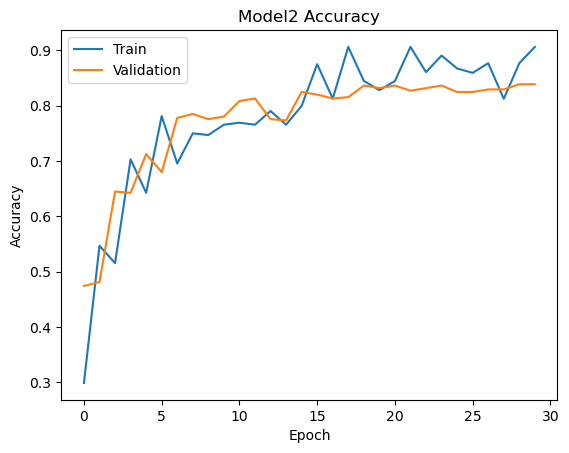

In [44]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [45]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - 9ms/step - accuracy: 0.8295 - loss: 0.5452


* Accuracey was improved compare the previous model


**Evaluate the model on test data**

In [46]:
y_pred=model2.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


**Plotting the Confusion Matrix**

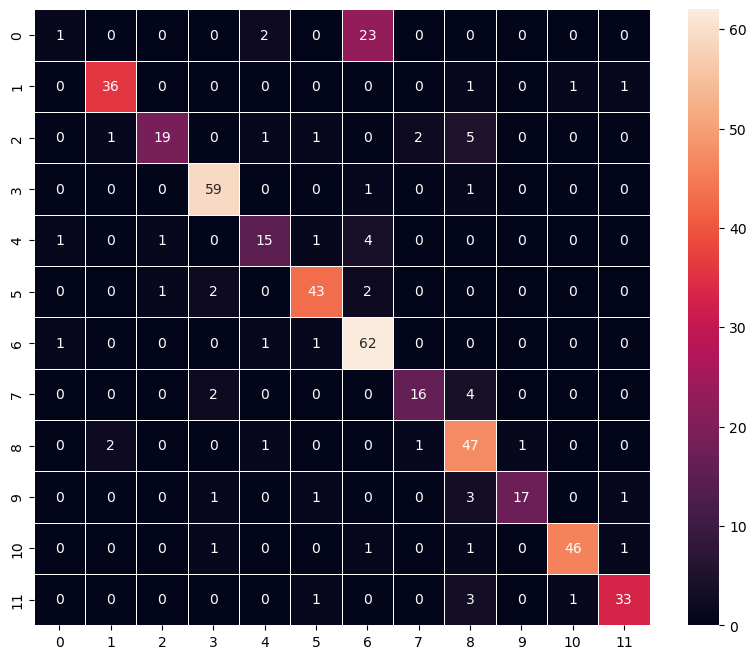

In [47]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Plotting Classification Report**

In [48]:
cr=metrics.classification_report(y_test_arg,y_pred_arg)
print(cr)

              precision    recall  f1-score   support

           0       0.33      0.04      0.07        26
           1       0.92      0.92      0.92        39
           2       0.90      0.66      0.76        29
           3       0.91      0.97      0.94        61
           4       0.75      0.68      0.71        22
           5       0.90      0.90      0.90        48
           6       0.67      0.95      0.78        65
           7       0.84      0.73      0.78        22
           8       0.72      0.90      0.80        52
           9       0.94      0.74      0.83        23
          10       0.96      0.92      0.94        50
          11       0.92      0.87      0.89        38

    accuracy                           0.83       475
   macro avg       0.81      0.77      0.78       475
weighted avg       0.82      0.83      0.81       475



# Transfer Learning using VGG16

In [49]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
backend.clear_session()
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64, 64,3))
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [51]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(16, activation='relu'))
new_model.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,988 (56.38 MB)

 Trainable params: 66,300 (258.98 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [52]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

history_vgg16 = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 230ms/step - accuracy: 0.2449 - loss: 2.2501 - val_accuracy: 0.5467 - val_loss: 1.5720
Epoch 2/30
 1/60 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 0.5000 - loss: 1.7455

2024-09-19 15:01:31.968356: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5000 - loss: 1.7455 - val_accuracy: 0.5607 - val_loss: 1.5608
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 236ms/step - accuracy: 0.4940 - loss: 1.5750 - val_accuracy: 0.6238 - val_loss: 1.1971
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5000 - loss: 1.3680 - val_accuracy: 0.6145 - val_loss: 1.1925
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 234ms/step - accuracy: 0.5756 - loss: 1.3142 - val_accuracy: 0.6776 - val_loss: 1.0035
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5469 - loss: 1.1942 - val_accuracy: 0.6822 - val_loss: 0.9992
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - accuracy: 0.6273 - loss: 1.1279 - val_accuracy: 0.6939 - val_loss: 0.9169
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5156 - loss: 1.2978 - val_accuracy: 0.6986 - val_loss: 0.9132
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - accuracy: 0.6407 - loss: 1.0125 - val_accuracy: 0.6846 - val_

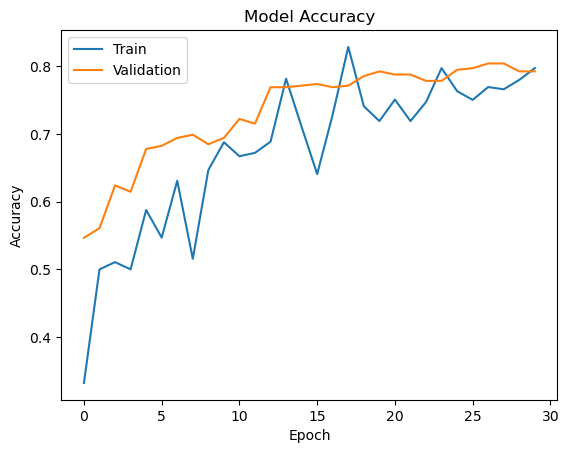

In [53]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [54]:
accuracy = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 2s - 114ms/step - accuracy: 0.8021 - loss: 0.6340


In [55]:
y_pred=new_model.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step


In [56]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

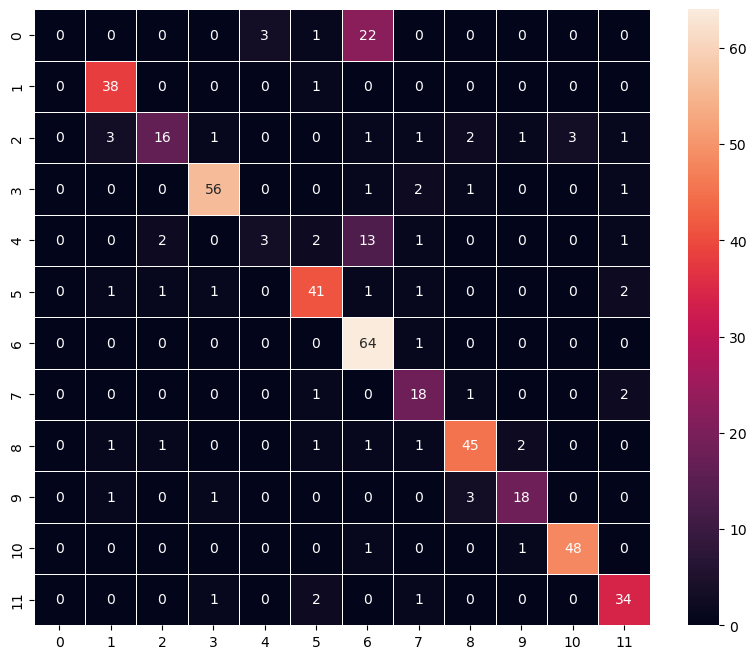

In [57]:
# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [58]:
# Plotting the classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg) 
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.86      0.97      0.92        39
           2       0.80      0.55      0.65        29
           3       0.93      0.92      0.93        61
           4       0.50      0.14      0.21        22
           5       0.84      0.85      0.85        48
           6       0.62      0.98      0.76        65
           7       0.69      0.82      0.75        22
           8       0.87      0.87      0.87        52
           9       0.82      0.78      0.80        23
          10       0.94      0.96      0.95        50
          11       0.83      0.89      0.86        38

    accuracy                           0.80       475
   macro avg       0.72      0.73      0.71       475
weighted avg       0.76      0.80      0.77       475



* The performance is lower than two previouse models

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

* The second model is selected. Both models had a resonable performance but, model1 had signs of overfittin which was not the case on the model2.

### Visualizing the prediction

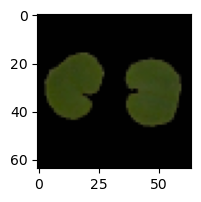

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


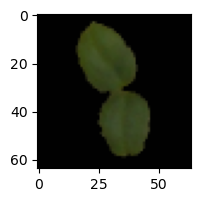

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predicted Label ['Cleavers']
True Label Cleavers


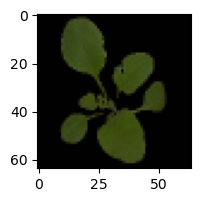

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


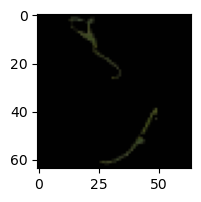

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted Label ['Loose Silky-bent']
True Label Loose Silky-bent


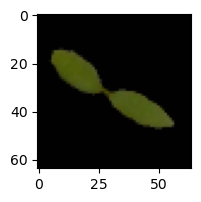

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


In [59]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])   


plt.figure(figsize=(2,2))
plt.imshow(X_test[10])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[10].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[10])   

plt.figure(figsize=(2,2))
plt.imshow(X_test[26])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[26].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[26])   

## Actionable Insights and Business Recommendations

* Three models were trained and model2 achieved a reasonable accuracy on the test dataset, indicating its ability to classify plant images effectively.
* Certain classes were more prone to misclassification than others, as observed in the confusion matrix.
* Analyzing the misclassified images and identifying patterns or characteristics that contribute to the misclassifications could provide valuable insights.
* The dataset exhibited a class imbalance, with some plant species having significantly more samples than others.

**Business Recommendations:**
* Automated Plant Identification: The trained model can be deployed as an automated plant identification system, enabling users to identify plant species based on images.

_____